In [1]:
import os
os.chdir('E:\Jupyterspace')

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [13]:
df=pd.read_csv('stock_dataset.csv')
data = np.array(df['prince_h'])
data=data[::-1] # 反转数据，使之按时间降序排列
data.shape

(6111,)

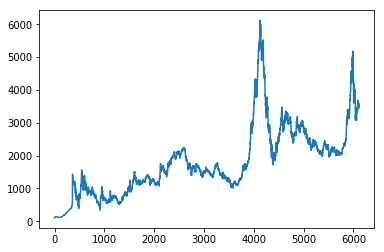

In [4]:
plt.figure()
plt.plot(data)
plt.show()

### 方法一

In [ ]:

# 数据标准化
normalize_data=(data-np.mean(data))/np.std(data)  #标准化
#增加数据维度
normalize_data=data[:,np.newaxis]  #增加维度，将一维数组变为二维
# [1,2,3,4] 转变为[[1],[2],[3],[4]]

# 模型设置参数
rnn_unit=30       # 设置隐层神经元个数
lr=0.01         #学习率
batch_size=60     #每一批次训练多少个样例
input_size=1      #输入维度
output_size=1     #输出维度
time_step=10      # 循环间隔

# 时间序列数据变为循环输入数据
train_x,train_y=[],[]   #训练集
for i in range(len(normalize_data)-time_step-1):
    x=normalize_data[i:i+time_step]
    y=normalize_data[i+time_step]
    train_x.append(x.tolist())
    train_y.append(y.tolist())
    
X=tf.placeholder(tf.float32, [None,time_step,input_size])    #每批次输入网络的tensor
Y=tf.placeholder(tf.float32, [None,time_step,output_size]) #每批次tensor对应的标签
#输入层、输出层权重、偏置
weights={
         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),
         'out':tf.Variable(tf.random_normal([rnn_unit,1]))
         }
biases={
        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),
        'out':tf.Variable(tf.constant(0.1,shape=[1,]))
        }

def lstm(batch):  #参数：输入网络批次数目
    w_in=weights['in']
    b_in=biases['in']
    input=tf.reshape(X,[-1,input_size])  #需要将tensor转成2维进行计算，计算后的结果作为隐藏层的输入
    input_rnn=tf.matmul(input,w_in)+b_in
    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])  #将tensor转成3维，作为lstm cell的输入
    
    cell=tf.nn.rnn_cell.BasicLSTMCell(num_units = rnn_unit)
    
    init_state=cell.zero_state(batch,dtype=tf.float32)
    
    #output_rnn是记录lstm每个输出节点的结果，final_states是最后一个cell的结果
    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)   
    output=tf.reshape(output_rnn,[-1,rnn_unit]) #作为输出层的输入
    
    w_out=weights['out']
    b_out=biases['out']
    pred=tf.matmul(output,w_out)+b_out
    return pred,final_states

def train_lstm():
    global batch_size
    with tf.variable_scope("sec_lstm"):
        pred,_=rnn(batch_size)
    #损失函数
    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))
    train_op=tf.train.AdamOptimizer(lr).minimize(loss)
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        #重复训练10000次
        for i in range(1000):
            step=0
            start=0
            end=start+batch_size
            while(end<len(train_x)):
                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[start:end],Y:train_y[start:end]})
                start+=batch_size
                end=start+batch_size
                #每10步保存一次参数
                if step%50==0:
                    print(i,step,loss_)
                    print("保存模型：",saver.save(sess,'stock.model'))
                step+=1

def prediction():
    with tf.variable_scope("sec_lstm",reuse=tf.AUTO_REUSE):
        pred,_=lstm(1)    #预测时只输入[1,time_step,input_size]的测试数据
    saver=tf.train.Saver(tf.global_variables())
    with tf.Session() as sess:
        #参数恢复
        saver.restore(sess, 'E:\Jupyterspace\Models') 
        #取训练集最后一行为测试样本。shape=[1,time_step,input_size]
        prev_seq=train_x[-1]
        predict=[]
        #得到之后100个预测结果
        for i in range(100):
            next_seq=sess.run(pred,feed_dict={X:[prev_seq]})
            predict.append(next_seq[-1])
            #每次得到最后一个时间步的预测结果，与之前的数据加在一起，形成新的测试样本
            prev_seq=np.vstack((prev_seq[1:],next_seq[-1]))
        #以折线图表示结果
        plt.figure()
        plt.plot(list(range(len(normalize_data))), normalize_data, color='b')
        plt.plot(list(range(len(normalize_data), len(normalize_data) + len(predict))), predict, color='r')
        plt.show()
                
prediction()

#-----------------------报错：PYTHON运行自动停止--------------------------------------#

INFO:tensorflow:Restoring parameters from E:\Jupyterspace\Models


### 参考sina单变量语句进行预测

In [5]:
# 数据标准化
def data_processing(raw_data,scale=True):
    if scale == True:
        return (raw_data-np.mean(raw_data))/np.std(raw_data)#标准化
    else:
        return (raw_data-np.min(raw_data))/(np.max(raw_data)-np.min(raw_data))

normalize_data = data_processing(data)

In [7]:
# 定义生成时间序列函数
time_step=10      # 循环间隔
def generate_data(seq):
    X = []
    Y = []   
    for i in range(len(seq) - time_step):
        X.append([seq[i:i + time_step]])
        Y.append([seq[i + time_step]])
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

train_x,train_y=generate_data(normalize_data)

In [8]:
# 神经网络参数
HIDDEN_SIZE = 30  # LSTM隐藏节点个数
NUM_LAYERS = 2  # LSTM层数
BATCH_SIZE = 60  # batch大小

TRAINING_STEPS = 1000  # 训练轮数


INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002C54B05B198>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': 'model/'}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from model/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 3000 into mod

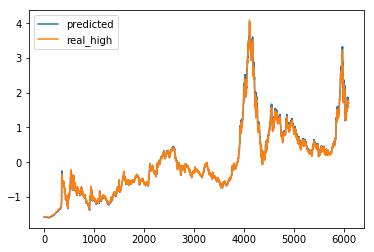

In [19]:
# TensorFlow的高层封装TFLearn
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat
learn = tf.contrib.learn

# LSTM结构单元
def LstmCell():
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(HIDDEN_SIZE)
    return lstm_cell


def lstm_model(X, y):
    # 使用多层LSTM，不能用lstm_cell*NUM_LAYERS的方法，会导致LSTM的tensor名字都一样
    cell = tf.contrib.rnn.MultiRNNCell([LstmCell() for _ in range(NUM_LAYERS)])

    # 将多层LSTM结构连接成RNN网络并计算前向传播结果
    output, _ = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    output = tf.reshape(output, [-1, HIDDEN_SIZE])

    # 通过无激活函数的全联接层计算线性回归，并将数据压缩成一维数组的结构
    predictions = tf.contrib.layers.fully_connected(output, 1, None)

    # 将predictions和labels调整为统一的shape
    y = tf.reshape(y, [-1])
    predictions = tf.reshape(predictions, [-1])

    # 计算损失值
    loss = tf.losses.mean_squared_error(predictions, y)

    # 创建模型优化器并得到优化步骤
    train_op = tf.contrib.layers.optimize_loss(
        loss,
        tf.train.get_global_step(),
        optimizer='Adagrad',
        learning_rate=0.1)

    return predictions, loss, train_op



# 建立深层循环网络模型
regressor = SKCompat(learn.Estimator(model_fn=lstm_model, model_dir='model/'))

# 调用fit函数训练模型
regressor.fit(train_x, train_y, batch_size=BATCH_SIZE, steps=TRAINING_STEPS)

# 使用训练好的模型对测试集进行预测
predicted = [[pred] for pred in regressor.predict(train_x)]

# 计算rmse作为评价指标
rmse = np.sqrt(((predicted - train_y)**2).mean(axis=0))
print('Mean Square Error is: %f' % (rmse[0]))

# 对预测曲线绘图
# 每10个值预测一次，而不是连续预测，下一步预测并未使用这一步的预测结果
fig = plt.figure()
plot_predicted, = plt.plot(predicted, label='predicted')
plot_test, = plt.plot(train_y, label='real_high')
plt.legend([plot_predicted, plot_test], ['predicted', 'real_high'])
plt.show()


In [2]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf


f=open('stock_dataset.csv')  

df=pd.read_csv(f)     

data=np.array(df['prince_h'])

data=data[::-1]      


#plt.figure()

#plt.plot(data)

#plt.show()

normalize_data=(data-np.mean(data))/np.std(data)  

normalize_data=normalize_data[:,np.newaxis]       





time_step=20      

rnn_unit=10      

lstm_layers=2

batch_size=60     

input_size=1      

output_size=1     

lr=0.0006         

train_x,train_y=[],[]   

for i in range(len(normalize_data)-time_step-1):

    x=normalize_data[i:i+time_step]

    y=normalize_data[i+1:i+time_step+1]

    train_x.append(x.tolist())

    train_y.append(y.tolist()) 





X=tf.placeholder(tf.float32, [None,time_step,input_size])    

Y=tf.placeholder(tf.float32, [None,time_step,output_size])   



weights={

         'in':tf.Variable(tf.random_normal([input_size,rnn_unit])),

         'out':tf.Variable(tf.random_normal([rnn_unit,1]))

         }

biases={

        'in':tf.Variable(tf.constant(0.1,shape=[rnn_unit,])),

        'out':tf.Variable(tf.constant(0.1,shape=[1,]))

        }





def lstm(batch):      

    w_in=weights['in']

    b_in=biases['in']

    input=tf.reshape(X,[-1,input_size])  

    input_rnn=tf.matmul(input,w_in)+b_in

    input_rnn=tf.reshape(input_rnn,[-1,time_step,rnn_unit])   

    cell = tf.nn.rnn_cell.MultiRNNCell([tf.nn.rnn_cell.BasicLSTMCell(rnn_unit) for i in range(lstm_layers)])

    init_state=cell.zero_state(batch,dtype=tf.float32)

    output_rnn,final_states=tf.nn.dynamic_rnn(cell, input_rnn,initial_state=init_state, dtype=tf.float32)

    output=tf.reshape(output_rnn,[-1,rnn_unit]) 

    w_out=weights['out']

    b_out=biases['out']

    pred=tf.matmul(output,w_out)+b_out

    return pred,final_states





def train_lstm():

    global batch_size

    with tf.variable_scope("sec_lstm"):

        pred,_=lstm(batch_size)

    loss=tf.reduce_mean(tf.square(tf.reshape(pred,[-1])-tf.reshape(Y, [-1])))

    train_op=tf.train.AdamOptimizer(lr).minimize(loss)

    saver=tf.train.Saver(tf.global_variables())

    with tf.Session() as sess:

        sess.run(tf.global_variables_initializer())

        

        for i in range(100): #We can increase the number of iterations to gain better result.

            step=0

            start=0

            end=start+batch_size

            while(end<len(train_x)):

                _,loss_=sess.run([train_op,loss],feed_dict={X:train_x[start:end],Y:train_y[start:end]})

                start+=batch_size

                end=start+batch_size

                

                if step%10==0:

                    print("Number of iterations:",i," loss:",loss_)

                    print("model_save",saver.save(sess,'model_save1\\modle.ckpt'))

                    #I run the code in windows 10,so use  'model_save1\\modle.ckpt'

                    #if you run it in Linux,please use  'model_save1/modle.ckpt'

                step+=1

        print("The train has finished")

train_lstm()


D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Number of iterations: 0  loss: 9.598503
model_save model_save1\modle.ckpt
Number of iterations: 0  loss: 2.442851
model_save model_save1\modle.ckpt
Number of iterations: 0  loss: 2.5432806
model_save model_save1\modle.ckpt
Number of iterations: 0  loss: 0.12916575
model_save model_save1\modle.ckpt
Number of iterations: 0  loss: 0.08450028
model_save model_save1\modle.ckpt
Number of iterations: 0  loss: 0.060727984
model_save model_save1\modle.ckpt
Number of iterations: 0  loss: 0.13205898
model_save model_save1\modle.ckpt
Number of iterations: 0  loss: 1.7462348
model_save model_save1\modle.ckpt
Number of iterations: 0  loss: 0.19500837
model_save model_save1\modle.ckpt
Number of iterations: 0  loss: 0.16571538
model_save model_save1\modle.ckpt
Number of iterations: 0  loss: 0.6378796
model_save model_save1\modle.ckpt
Number of iterations: 1  loss: 2.1703348
model_save model_save1\modle.ckpt
Number of iterations: 1  loss: 0.134061
model_save model_save1\modle.ckpt
Number of iterations:

model_save model_save1\modle.ckpt
Number of iterations: 9  loss: 0.19830881
model_save model_save1\modle.ckpt
Number of iterations: 10  loss: 0.2758542
model_save model_save1\modle.ckpt
Number of iterations: 10  loss: 0.040699203
model_save model_save1\modle.ckpt
Number of iterations: 10  loss: 0.0705502
model_save model_save1\modle.ckpt
Number of iterations: 10  loss: 0.020239834
model_save model_save1\modle.ckpt
Number of iterations: 10  loss: 0.006692609
model_save model_save1\modle.ckpt
Number of iterations: 10  loss: 0.010581867
model_save model_save1\modle.ckpt
Number of iterations: 10  loss: 0.027782619
model_save model_save1\modle.ckpt
Number of iterations: 10  loss: 0.3024372
model_save model_save1\modle.ckpt
Number of iterations: 10  loss: 0.04393456
model_save model_save1\modle.ckpt
Number of iterations: 10  loss: 0.01794001
model_save model_save1\modle.ckpt
Number of iterations: 10  loss: 0.18875593
model_save model_save1\modle.ckpt
Number of iterations: 11  loss: 0.2711002

model_save model_save1\modle.ckpt
Number of iterations: 19  loss: 0.015646614
model_save model_save1\modle.ckpt
Number of iterations: 19  loss: 0.15681958
model_save model_save1\modle.ckpt
Number of iterations: 19  loss: 0.023028154
model_save model_save1\modle.ckpt
Number of iterations: 19  loss: 0.011878594
model_save model_save1\modle.ckpt
Number of iterations: 19  loss: 0.102454856
model_save model_save1\modle.ckpt
Number of iterations: 20  loss: 0.12718308
model_save model_save1\modle.ckpt
Number of iterations: 20  loss: 0.02230983
model_save model_save1\modle.ckpt
Number of iterations: 20  loss: 0.040186632
model_save model_save1\modle.ckpt
Number of iterations: 20  loss: 0.010802457
model_save model_save1\modle.ckpt
Number of iterations: 20  loss: 0.007491032
model_save model_save1\modle.ckpt
Number of iterations: 20  loss: 0.0049678953
model_save model_save1\modle.ckpt
Number of iterations: 20  loss: 0.014642165
model_save model_save1\modle.ckpt
Number of iterations: 20  loss: 

model_save model_save1\modle.ckpt
Number of iterations: 29  loss: 0.021638399
model_save model_save1\modle.ckpt
Number of iterations: 29  loss: 0.0067028175
model_save model_save1\modle.ckpt
Number of iterations: 29  loss: 0.005415907
model_save model_save1\modle.ckpt
Number of iterations: 29  loss: 0.0028559559
model_save model_save1\modle.ckpt
Number of iterations: 29  loss: 0.008330906
model_save model_save1\modle.ckpt
Number of iterations: 29  loss: 0.07914648
model_save model_save1\modle.ckpt
Number of iterations: 29  loss: 0.013559702
model_save model_save1\modle.ckpt
Number of iterations: 29  loss: 0.004745013
model_save model_save1\modle.ckpt
Number of iterations: 29  loss: 0.05369775
model_save model_save1\modle.ckpt
Number of iterations: 30  loss: 0.06538239
model_save model_save1\modle.ckpt
Number of iterations: 30  loss: 0.012002319
model_save model_save1\modle.ckpt
Number of iterations: 30  loss: 0.020100415
model_save model_save1\modle.ckpt
Number of iterations: 30  loss:

model_save model_save1\modle.ckpt
Number of iterations: 38  loss: 0.008046403
model_save model_save1\modle.ckpt
Number of iterations: 38  loss: 0.0023834757
model_save model_save1\modle.ckpt
Number of iterations: 38  loss: 0.030080503
model_save model_save1\modle.ckpt
Number of iterations: 39  loss: 0.036096856
model_save model_save1\modle.ckpt
Number of iterations: 39  loss: 0.0066276286
model_save model_save1\modle.ckpt
Number of iterations: 39  loss: 0.009512272
model_save model_save1\modle.ckpt
Number of iterations: 39  loss: 0.0026344433
model_save model_save1\modle.ckpt
Number of iterations: 39  loss: 0.0022437319
model_save model_save1\modle.ckpt
Number of iterations: 39  loss: 0.0019203377
model_save model_save1\modle.ckpt
Number of iterations: 39  loss: 0.0038561637
model_save model_save1\modle.ckpt
Number of iterations: 39  loss: 0.040490605
model_save model_save1\modle.ckpt
Number of iterations: 39  loss: 0.0075391084
model_save model_save1\modle.ckpt
Number of iterations: 3

model_save model_save1\modle.ckpt
Number of iterations: 48  loss: 0.0010071942
model_save model_save1\modle.ckpt
Number of iterations: 48  loss: 0.0010015237
model_save model_save1\modle.ckpt
Number of iterations: 48  loss: 0.0012454814
model_save model_save1\modle.ckpt
Number of iterations: 48  loss: 0.0014683357
model_save model_save1\modle.ckpt
Number of iterations: 48  loss: 0.02130135
model_save model_save1\modle.ckpt
Number of iterations: 48  loss: 0.0042738174
model_save model_save1\modle.ckpt
Number of iterations: 48  loss: 0.0014391032
model_save model_save1\modle.ckpt
Number of iterations: 48  loss: 0.015448314
model_save model_save1\modle.ckpt
Number of iterations: 49  loss: 0.016715586
model_save model_save1\modle.ckpt
Number of iterations: 49  loss: 0.003293623
model_save model_save1\modle.ckpt
Number of iterations: 49  loss: 0.0031544892
model_save model_save1\modle.ckpt
Number of iterations: 49  loss: 0.00090079906
model_save model_save1\modle.ckpt
Number of iterations: 

model_save model_save1\modle.ckpt
Number of iterations: 57  loss: 0.002741853
model_save model_save1\modle.ckpt
Number of iterations: 57  loss: 0.00085336796
model_save model_save1\modle.ckpt
Number of iterations: 57  loss: 0.01017642
model_save model_save1\modle.ckpt
Number of iterations: 58  loss: 0.007774543
model_save model_save1\modle.ckpt
Number of iterations: 58  loss: 0.002089611
model_save model_save1\modle.ckpt
Number of iterations: 58  loss: 0.0008007964
model_save model_save1\modle.ckpt
Number of iterations: 58  loss: 0.0003717571
model_save model_save1\modle.ckpt
Number of iterations: 58  loss: 0.00039059218
model_save model_save1\modle.ckpt
Number of iterations: 58  loss: 0.0004973554
model_save model_save1\modle.ckpt
Number of iterations: 58  loss: 0.000406025
model_save model_save1\modle.ckpt
Number of iterations: 58  loss: 0.012145571
model_save model_save1\modle.ckpt
Number of iterations: 58  loss: 0.002270612
model_save model_save1\modle.ckpt
Number of iterations: 58

model_save model_save1\modle.ckpt
Number of iterations: 67  loss: 0.0007276848
model_save model_save1\modle.ckpt
Number of iterations: 67  loss: 0.0027706989
model_save model_save1\modle.ckpt
Number of iterations: 67  loss: 0.0019592412
model_save model_save1\modle.ckpt
Number of iterations: 67  loss: 0.00033804844
model_save model_save1\modle.ckpt
Number of iterations: 67  loss: 0.022331005
model_save model_save1\modle.ckpt
Number of iterations: 67  loss: 0.009191634
model_save model_save1\modle.ckpt
Number of iterations: 67  loss: 0.0005907489
model_save model_save1\modle.ckpt
Number of iterations: 67  loss: 0.027340483
model_save model_save1\modle.ckpt
Number of iterations: 68  loss: 0.006721495
model_save model_save1\modle.ckpt
Number of iterations: 68  loss: 0.0018549224
model_save model_save1\modle.ckpt
Number of iterations: 68  loss: 0.00021972707
model_save model_save1\modle.ckpt
Number of iterations: 68  loss: 0.0017564597
model_save model_save1\modle.ckpt
Number of iterations

model_save model_save1\modle.ckpt
Number of iterations: 76  loss: 0.001233844
model_save model_save1\modle.ckpt
Number of iterations: 76  loss: 0.018163837
model_save model_save1\modle.ckpt
Number of iterations: 77  loss: 0.0033575837
model_save model_save1\modle.ckpt
Number of iterations: 77  loss: 0.0018485476
model_save model_save1\modle.ckpt
Number of iterations: 77  loss: 0.00048536394
model_save model_save1\modle.ckpt
Number of iterations: 77  loss: 0.0010908339
model_save model_save1\modle.ckpt
Number of iterations: 77  loss: 0.0012263422
model_save model_save1\modle.ckpt
Number of iterations: 77  loss: 0.0010263686
model_save model_save1\modle.ckpt
Number of iterations: 77  loss: 0.00037387438
model_save model_save1\modle.ckpt
Number of iterations: 77  loss: 0.012653354
model_save model_save1\modle.ckpt
Number of iterations: 77  loss: 0.0011810602
model_save model_save1\modle.ckpt
Number of iterations: 77  loss: 0.0010709543
model_save model_save1\modle.ckpt
Number of iteration

model_save model_save1\modle.ckpt
Number of iterations: 86  loss: 0.0004846627
model_save model_save1\modle.ckpt
Number of iterations: 86  loss: 0.0011069292
model_save model_save1\modle.ckpt
Number of iterations: 86  loss: 0.000945597
model_save model_save1\modle.ckpt
Number of iterations: 86  loss: 0.00021582156
model_save model_save1\modle.ckpt
Number of iterations: 86  loss: 0.01200178
model_save model_save1\modle.ckpt
Number of iterations: 86  loss: 0.0022387344
model_save model_save1\modle.ckpt
Number of iterations: 86  loss: 0.00051084725
model_save model_save1\modle.ckpt
Number of iterations: 86  loss: 0.015077076
model_save model_save1\modle.ckpt
Number of iterations: 87  loss: 0.0025677744
model_save model_save1\modle.ckpt
Number of iterations: 87  loss: 0.0016110576
model_save model_save1\modle.ckpt
Number of iterations: 87  loss: 0.00018789562
model_save model_save1\modle.ckpt
Number of iterations: 87  loss: 0.00045475343
model_save model_save1\modle.ckpt
Number of iteratio

model_save model_save1\modle.ckpt
Number of iterations: 95  loss: 0.004361377
model_save model_save1\modle.ckpt
Number of iterations: 95  loss: 0.0005750289
model_save model_save1\modle.ckpt
Number of iterations: 95  loss: 0.022758137
model_save model_save1\modle.ckpt
Number of iterations: 96  loss: 0.0021251568
model_save model_save1\modle.ckpt
Number of iterations: 96  loss: 0.0015860752
model_save model_save1\modle.ckpt
Number of iterations: 96  loss: 0.00019380607
model_save model_save1\modle.ckpt
Number of iterations: 96  loss: 0.00097038515
model_save model_save1\modle.ckpt
Number of iterations: 96  loss: 0.00215525
model_save model_save1\modle.ckpt
Number of iterations: 96  loss: 0.0020143327
model_save model_save1\modle.ckpt
Number of iterations: 96  loss: 0.00021576021
model_save model_save1\modle.ckpt
Number of iterations: 96  loss: 0.01881975
model_save model_save1\modle.ckpt
Number of iterations: 96  loss: 0.0042510293
model_save model_save1\modle.ckpt
Number of iterations:

In [3]:
f.close()

INFO:tensorflow:Restoring parameters from model_save1\modle.ckpt


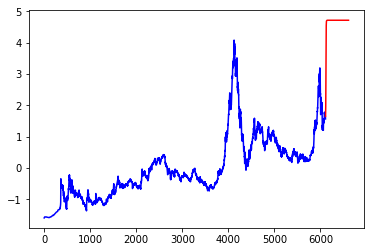

In [4]:
def prediction():

    with tf.variable_scope("sec_lstm",reuse=tf.AUTO_REUSE):

        pred,_=lstm(1)    

    saver=tf.train.Saver(tf.global_variables())

    with tf.Session() as sess:

        saver.restore(sess, 'model_save1\\modle.ckpt') 

        #I run the code in windows 10,so use  'model_save1\\modle.ckpt'

        #if you run it in Linux,please use  'model_save1/modle.ckpt'

        prev_seq=train_x[-1]

        predict=[]

        for i in range(500):

            next_seq=sess.run(pred,feed_dict={X:[prev_seq]})

            predict.append(next_seq[-1])

            prev_seq=np.vstack((prev_seq[1:],next_seq[-1]))

        

        plt.figure()

        plt.plot(list(range(len(normalize_data))), normalize_data, color='b')

        plt.plot(list(range(len(normalize_data), len(normalize_data) + len(predict))), predict, color='r')

        plt.show()

        

prediction() 